In [ ]:
import scanpy as sc
import numpy as np
import pandas as pd
import time
import scvi
import anndata
import pandas as pd
from scipy.io import mmread
from scipy.sparse import csr_matrix
import umap
import matplotlib.pyplot as plt
import os
import tempfile
import seaborn as sns
import torch
import scgen
import harmonypy as hm

In [2]:
import warnings

sc.set_figure_params(figsize=(6, 6), frameon=False)
sns.set_theme()
torch.set_float32_matmul_precision("high")
save_dir = tempfile.TemporaryDirectory()

%config InlineBackend.print_figure_kwargs={"facecolor": "w"}
%config InlineBackend.figure_format="retina"

# Suppress specific ImportWarning
warnings.filterwarnings("ignore")

# Import the data

In [3]:
adata = anndata.read_h5ad("../human_immune.h5ad")
adata

AnnData object with n_obs × n_vars = 33506 × 12303
    obs: 'batch', 'chemistry', 'data_type', 'dpt_pseudotime', 'final_annotation', 'mt_frac', 'n_counts', 'n_genes', 'sample_ID', 'size_factors', 'species', 'study', 'tissue'
    layers: 'counts'

In [4]:
embeddings_dict = {}

In [5]:
adata.obs['cell_type'] = adata.obs['final_annotation'].astype('category')

### Setting: randomly wrong labels

In [ ]:
### Setting: randomly wrong labels
import numpy as np
import pandas as pd

# Set the random seed for reproducibility
np.random.seed(666)

# Total number of cells in the dataset
total_cells = adata.n_obs

# Get the list of all unique cell types available in the data
unique_cell_types = adata.obs['cell_type'].unique()

def apply_randomly_wrong_labels(adata, prop_wrong):
    """
    This function takes an AnnData object (adata) and a proportion of cells (prop_wrong)
    that should have the wrong label. For each selected cell, the current label from
    'cell_type' is replaced with a random alternative label (ensuring it differs from 
    the true label).
    
    Parameters:
      - adata: the AnnData object with an obs column 'cell_type'
      - prop_wrong: the proportion of cells to mislabel (e.g., 0.3 for 30%)
      
    The new labels are stored in a new column named "hard_label_wrong_X" where X
    is the integer percentage (e.g., hard_label_wrong_30).
    """
    # Make a copy of the true labels
    wrong_labels = adata.obs['cell_type'].copy()
    
    # Determine the number of cells to randomly mislabel
    num_wrong = int(prop_wrong * total_cells)
    
    # Randomly select indices (cells) without replacement that will be mislabelled
    indices_wrong = np.random.choice(adata.obs.index, size=num_wrong, replace=False)
    
    # For each chosen index, replace the label with a random wrong label
    for idx in indices_wrong:
        true_label = adata.obs.loc[idx, 'cell_type']
        # Exclude the true label from the list of potential alternatives
        wrong_choices = [ct for ct in unique_cell_types if ct != true_label]
        # If there is at least one alternative available, randomly choose one
        if wrong_choices:
            wrong_label = np.random.choice(wrong_choices)
            wrong_labels.loc[idx] = wrong_label
            
    # Create a new column name based on the wrong proportion (e.g., hard_label_wrong_50)
    new_label_col = "new_labels"
    adata.obs[new_label_col] = wrong_labels.astype('category')
    
    return adata

In [ ]:
# Apply the function for different proportions:

# 1. 30% wrong labels
adata = apply_randomly_wrong_labels(adata, 0.3)

# # 2. 50% wrong labels
# adata = apply_randomly_wrong_labels(adata, 0.5)

# # 3. 70% wrong labels
# adata = apply_randomly_wrong_labels(adata, 0.7)


In [ ]:
adata.obs['celltype'] = adata.obs['new_labels'].astype('category')

In [ ]:
# Write `adata.obs` to a CSV file named 'metadata.csv'
adata.obs.to_csv('../R_human_immune/labels/randomly_wrong_human_immune_30_obs.csv', index=True)

### Read the labels

In [6]:
# Read the CSV with the index
new_labels_df = pd.read_csv("../R_human_immune/labels/randomly_wrong_human_immune_30_obs.csv", index_col=0)

# Assign the 'new_labels' column back to adata.obs
adata.obs['new_labels'] = new_labels_df['new_labels']

In [7]:
# preprocessing
adata.raw = adata
adata.layers["counts"] = adata.X.copy()
sc.pp.filter_cells(adata, min_genes=300)
sc.pp.filter_genes(adata, min_cells=5)
sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata, n_top_genes=2000, batch_key='batch')
adata = adata[:, adata.var['highly_variable']]

# scANVI

In [ ]:
# scVI
adata = adata.copy()
# adata.layers['counts'] = adata.X
scvi.model.SCVI.setup_anndata(adata, layer="counts", batch_key="batch")
vae = scvi.model.SCVI(adata, n_layers=2, n_latent=50, gene_likelihood="nb")
vae.train()
adata.obsm["X_scVI"] = vae.get_latent_representation()
sc.pp.neighbors(adata, use_rep="X_scVI")
sc.tl.umap(adata, min_dist=0.5)

In [ ]:
# Save the trained model to a specified path
model_path = "./model_scVI"
vae.save(model_path, overwrite=True)

In [ ]:
# Save embeddings
adata.obsm["X_scVI"] = adata.obsm["X_scVI"]

# Collect embeddings
embeddings_dict["X_scVI"] = adata.obsm["X_scVI"]

In [ ]:
sc.pl.umap(adata, color=["batch", "cell_type"], frameon=False, ncols=1)

In [8]:
# Set up the AnnData object
adata = adata.copy()
scvi.model.SCVI.setup_anndata(adata, layer="counts", batch_key="batch")

# Load the trained model
model_path = "./model_scVI"
vae = scvi.model.SCVI.load(model_path, adata=adata)

# Now you can use the loaded model for further analysis or inference
adata.obsm["X_scVI"] = vae.get_latent_representation()
sc.pp.neighbors(adata, use_rep="X_scVI")
sc.tl.umap(adata, min_dist=0.5)

INFO     File ./model_scVI/model.pt already downloaded                                                             


scANVI should be initialized from a scVI model pre-trained on the same exact data.

In [9]:
scanvi_model = scvi.model.SCANVI.from_scvi_model(
    vae,
    adata=adata,
    labels_key="new_labels",
    unlabeled_category="Unknown",
)

In [10]:
scanvi_model.train(max_epochs=20, n_samples_per_label=100)

INFO     Training for 20 epochs.                                                                                   


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Epoch 20/20: 100%|██████████| 20/20 [06:06<00:00, 19.50s/it, v_num=1, train_loss_step=469, train_loss_epoch=511]

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 20/20: 100%|██████████| 20/20 [06:06<00:00, 18.31s/it, v_num=1, train_loss_step=469, train_loss_epoch=511]


In [11]:
SCANVI_LATENT_KEY = "X_scANVI"
SCANVI_PREDICTIONS_KEY = "C_scANVI"

adata.obsm[SCANVI_LATENT_KEY] = scanvi_model.get_latent_representation(adata)
adata.obs[SCANVI_PREDICTIONS_KEY] = scanvi_model.predict(adata)

In [12]:
# Save the embeddings
# Collect scANVI embeddings and predictions in the dictionary
embeddings_dict[SCANVI_LATENT_KEY] = adata.obsm[SCANVI_LATENT_KEY]
embeddings_dict[SCANVI_PREDICTIONS_KEY] = adata.obs[SCANVI_PREDICTIONS_KEY]

In [13]:
sc.pp.neighbors(adata, use_rep=SCANVI_LATENT_KEY)
sc.tl.umap(adata)

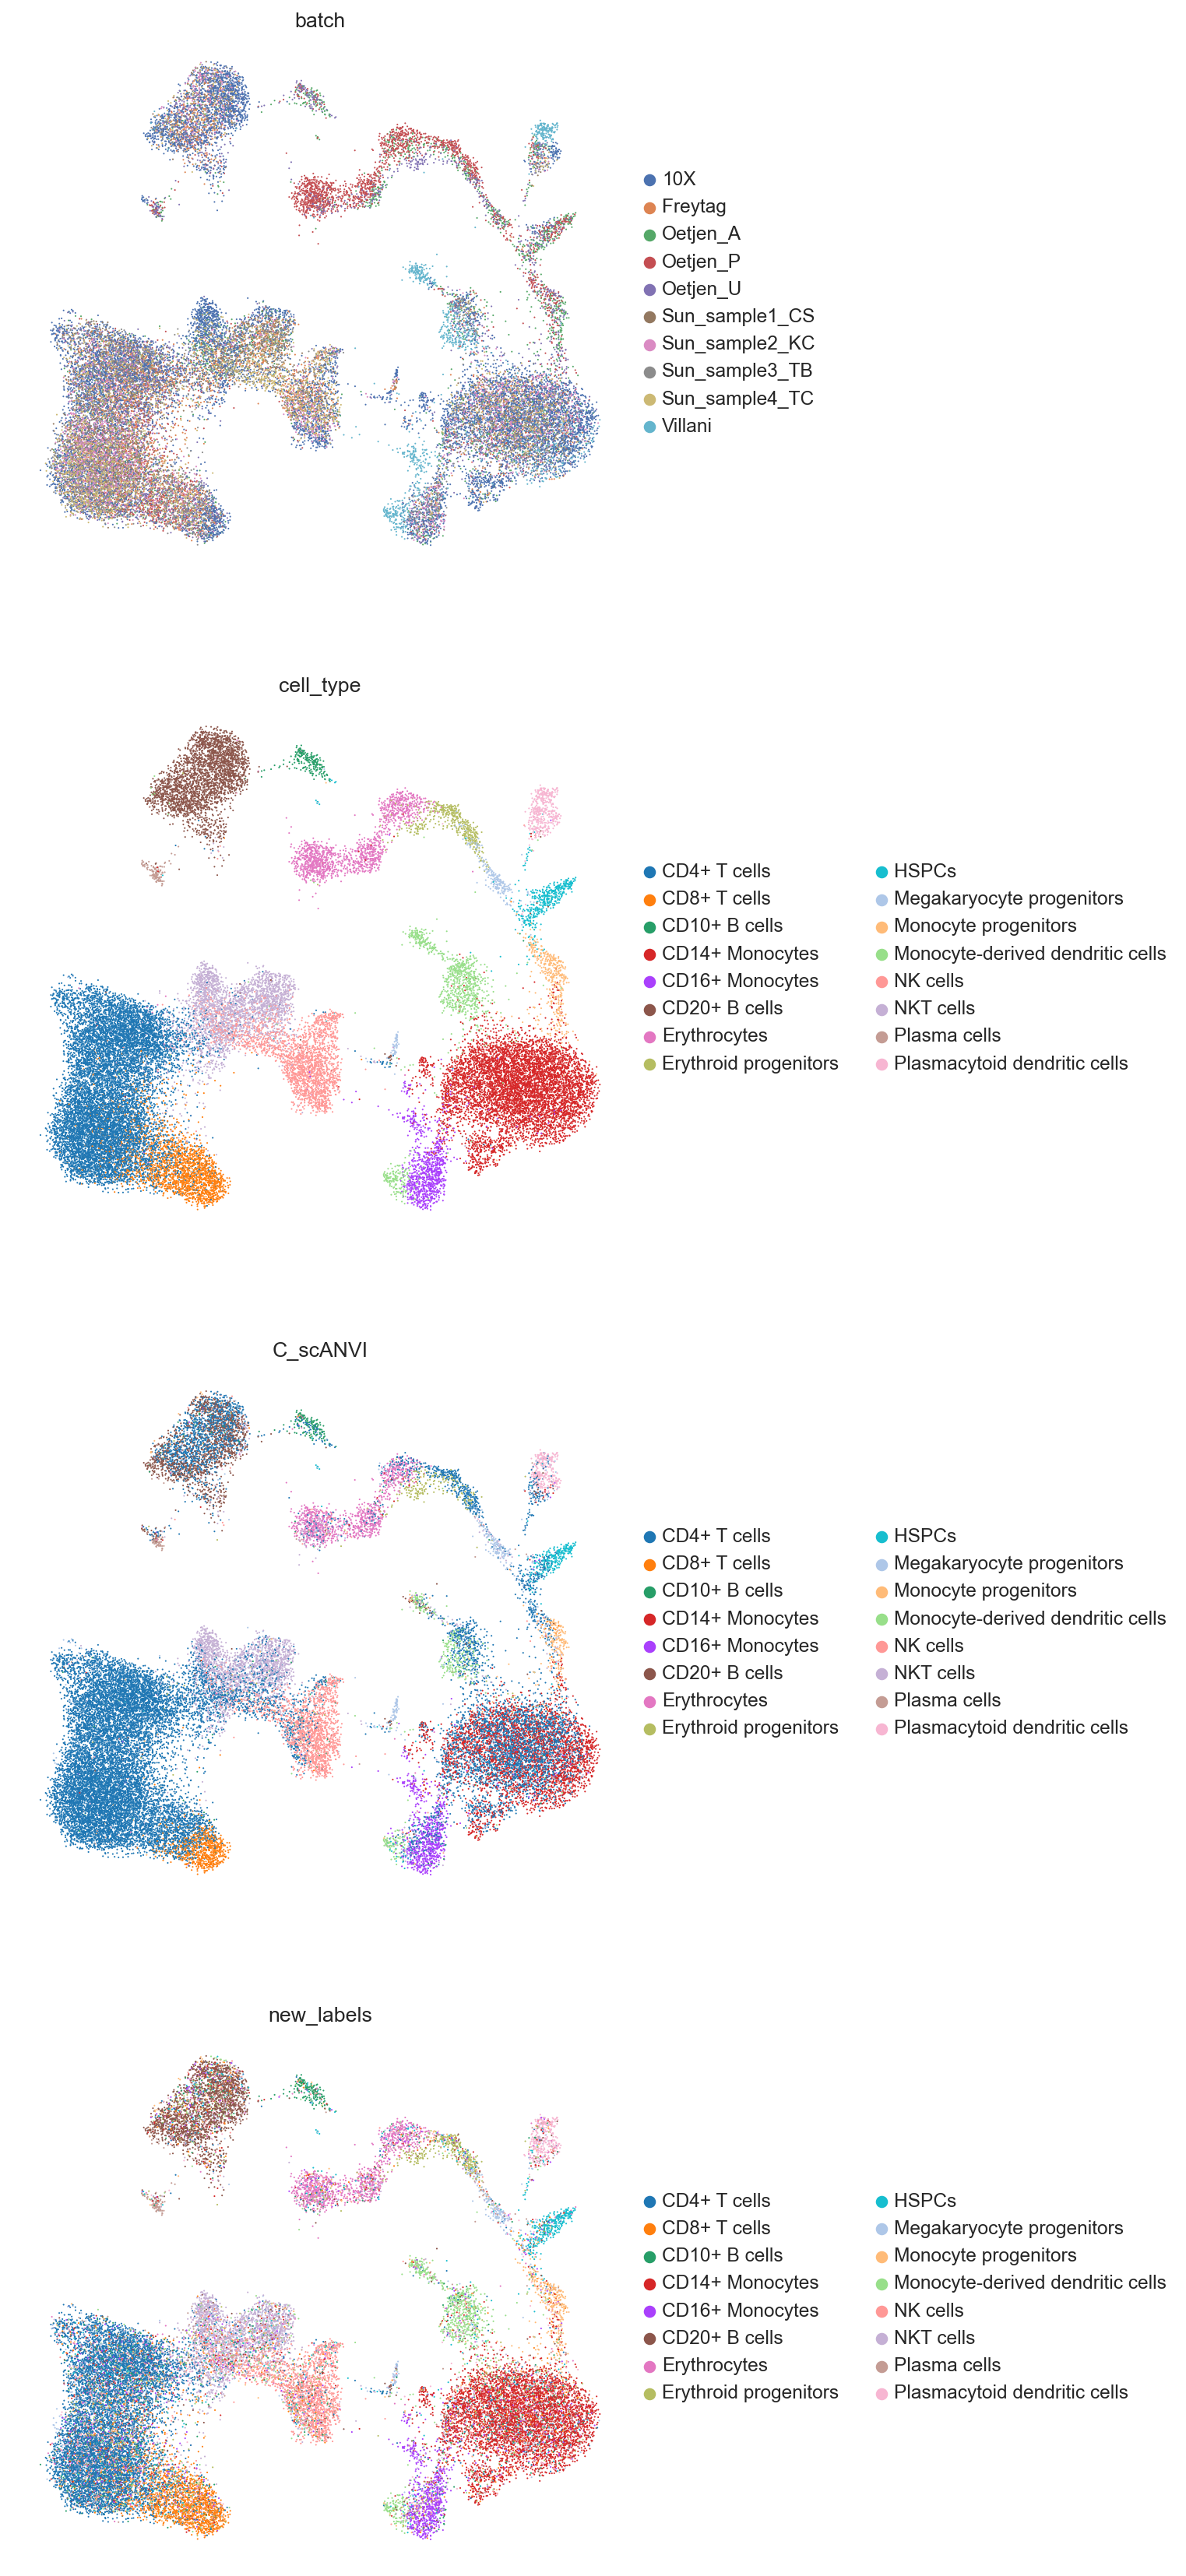

In [14]:
sc.pl.umap(adata, color=["batch", "cell_type", "C_scANVI", "new_labels"], frameon=False, ncols=1)

# scGEN

In [15]:
train = adata.copy()

### Preprocessing Data

In [16]:
scgen.SCGEN.setup_anndata(train, batch_key="batch", labels_key="new_labels")

## Creating and Training the model¶

In [17]:
model = scgen.SCGEN(train)

model.train(
    max_epochs=100,
    batch_size=32,
    early_stopping=True,
    early_stopping_patience=25,
)
# model.save("../saved_models/model_batch_removal.pt", overwrite=True)

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Epoch 26/100:  26%|██▌       | 26/100 [16:23<46:40, 37.85s/it, v_num=1, train_loss_step=211, train_loss_epoch=197]
Monitored metric elbo_validation did not improve in the last 25 records. Best score: 1177.468. Signaling Trainer to stop.


## Batch-Removal

In [18]:
corrected_adata = model.batch_removal()
corrected_adata

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


AnnData object with n_obs × n_vars = 33506 × 2000
    obs: 'batch', 'chemistry', 'data_type', 'dpt_pseudotime', 'final_annotation', 'mt_frac', 'n_counts', 'n_genes', 'sample_ID', 'size_factors', 'species', 'study', 'tissue', 'cell_type', 'new_labels', '_scvi_batch', '_scvi_labels', 'C_scANVI'
    uns: '_scvi_uuid', '_scvi_manager_uuid'
    obsm: 'latent', 'corrected_latent'

In [19]:
# Save embeddings
corrected_adata.obsm["X_scgen"] = corrected_adata.obsm["latent"]

# Collect embeddings
embeddings_dict["X_scgen"] = corrected_adata.obsm["X_scgen"]

### Visualization of the corrected gene expression data¶

In [20]:
sc.pp.neighbors(corrected_adata)
sc.tl.umap(corrected_adata)

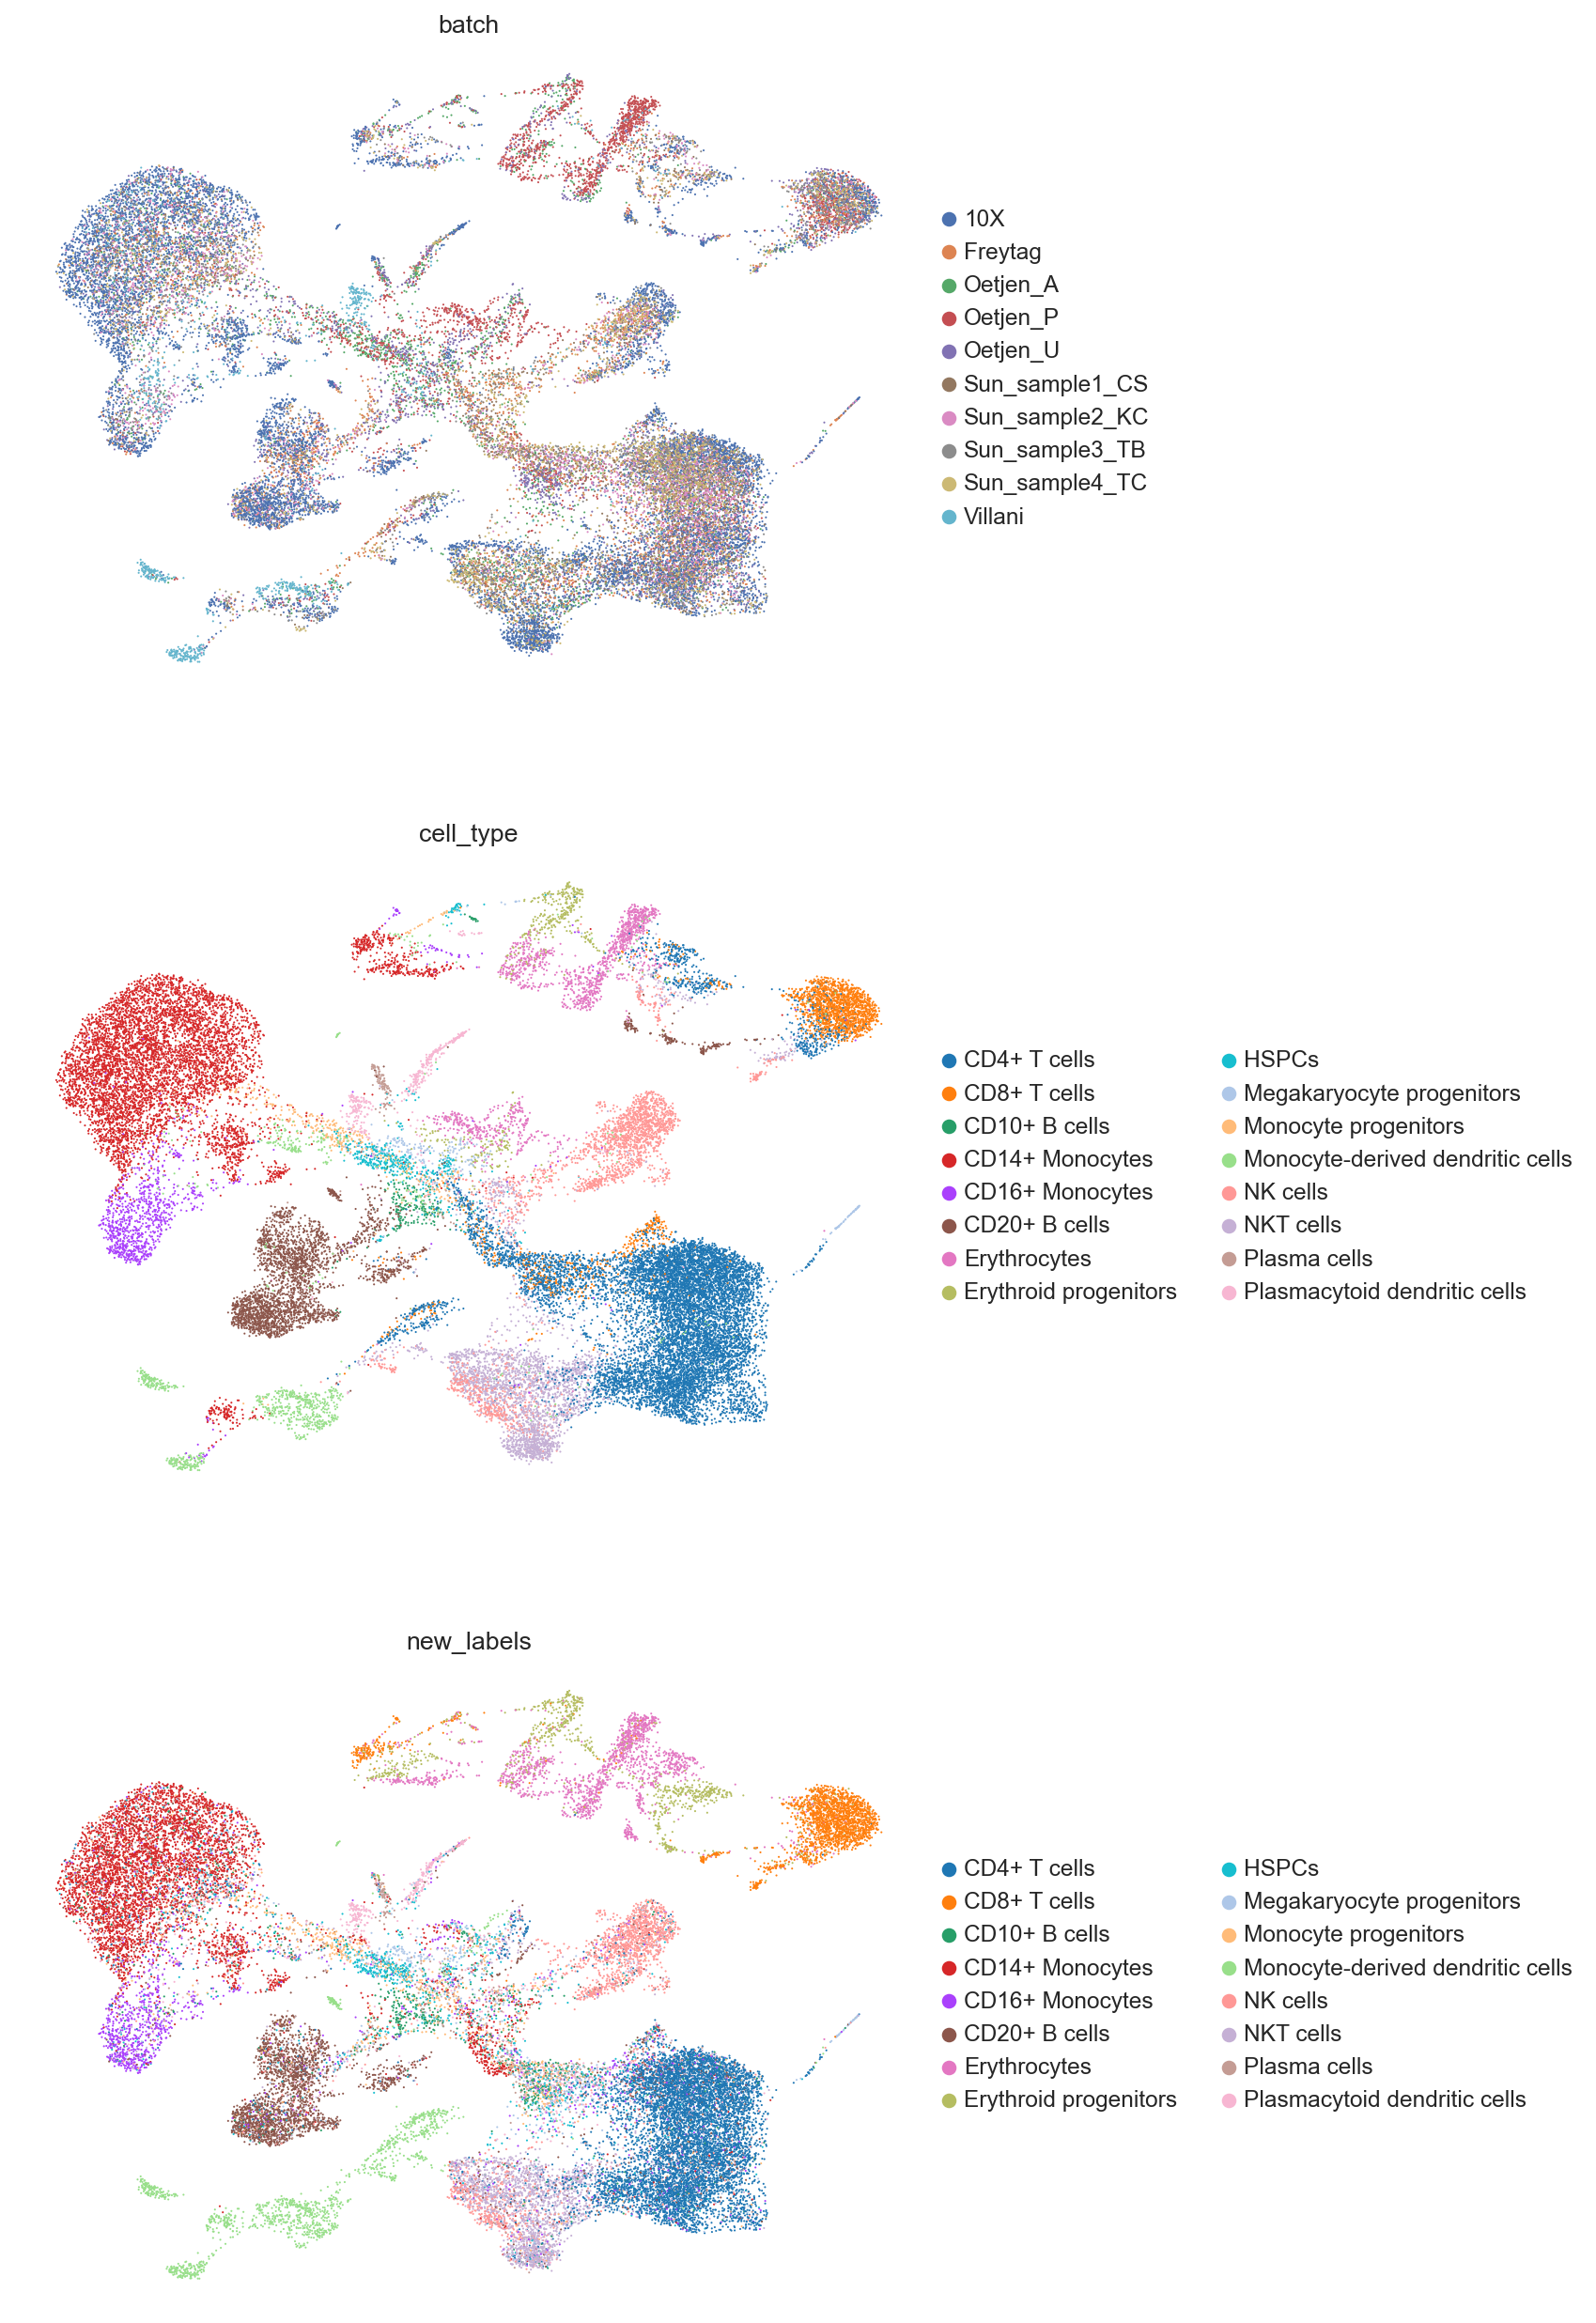

In [21]:
sc.pl.umap(corrected_adata, color=['batch', 'cell_type', 'new_labels'], wspace=0.4, frameon=False, ncols=1)

# STACAS

Semi-supervised integration results

In [22]:
pca_embeddings = pd.read_csv('../R_human_immune/embeddings/human_immune_stacas_embeddings_randomly_wrong_30.csv', index_col=0)
adata.obsm['X_stacas'] = pca_embeddings.values
sc.pp.neighbors(adata, use_rep="X_stacas")
sc.tl.umap(adata, min_dist=0.5)

In [23]:
# Collect embeddings
embeddings_dict["X_stacas"] = pca_embeddings.values

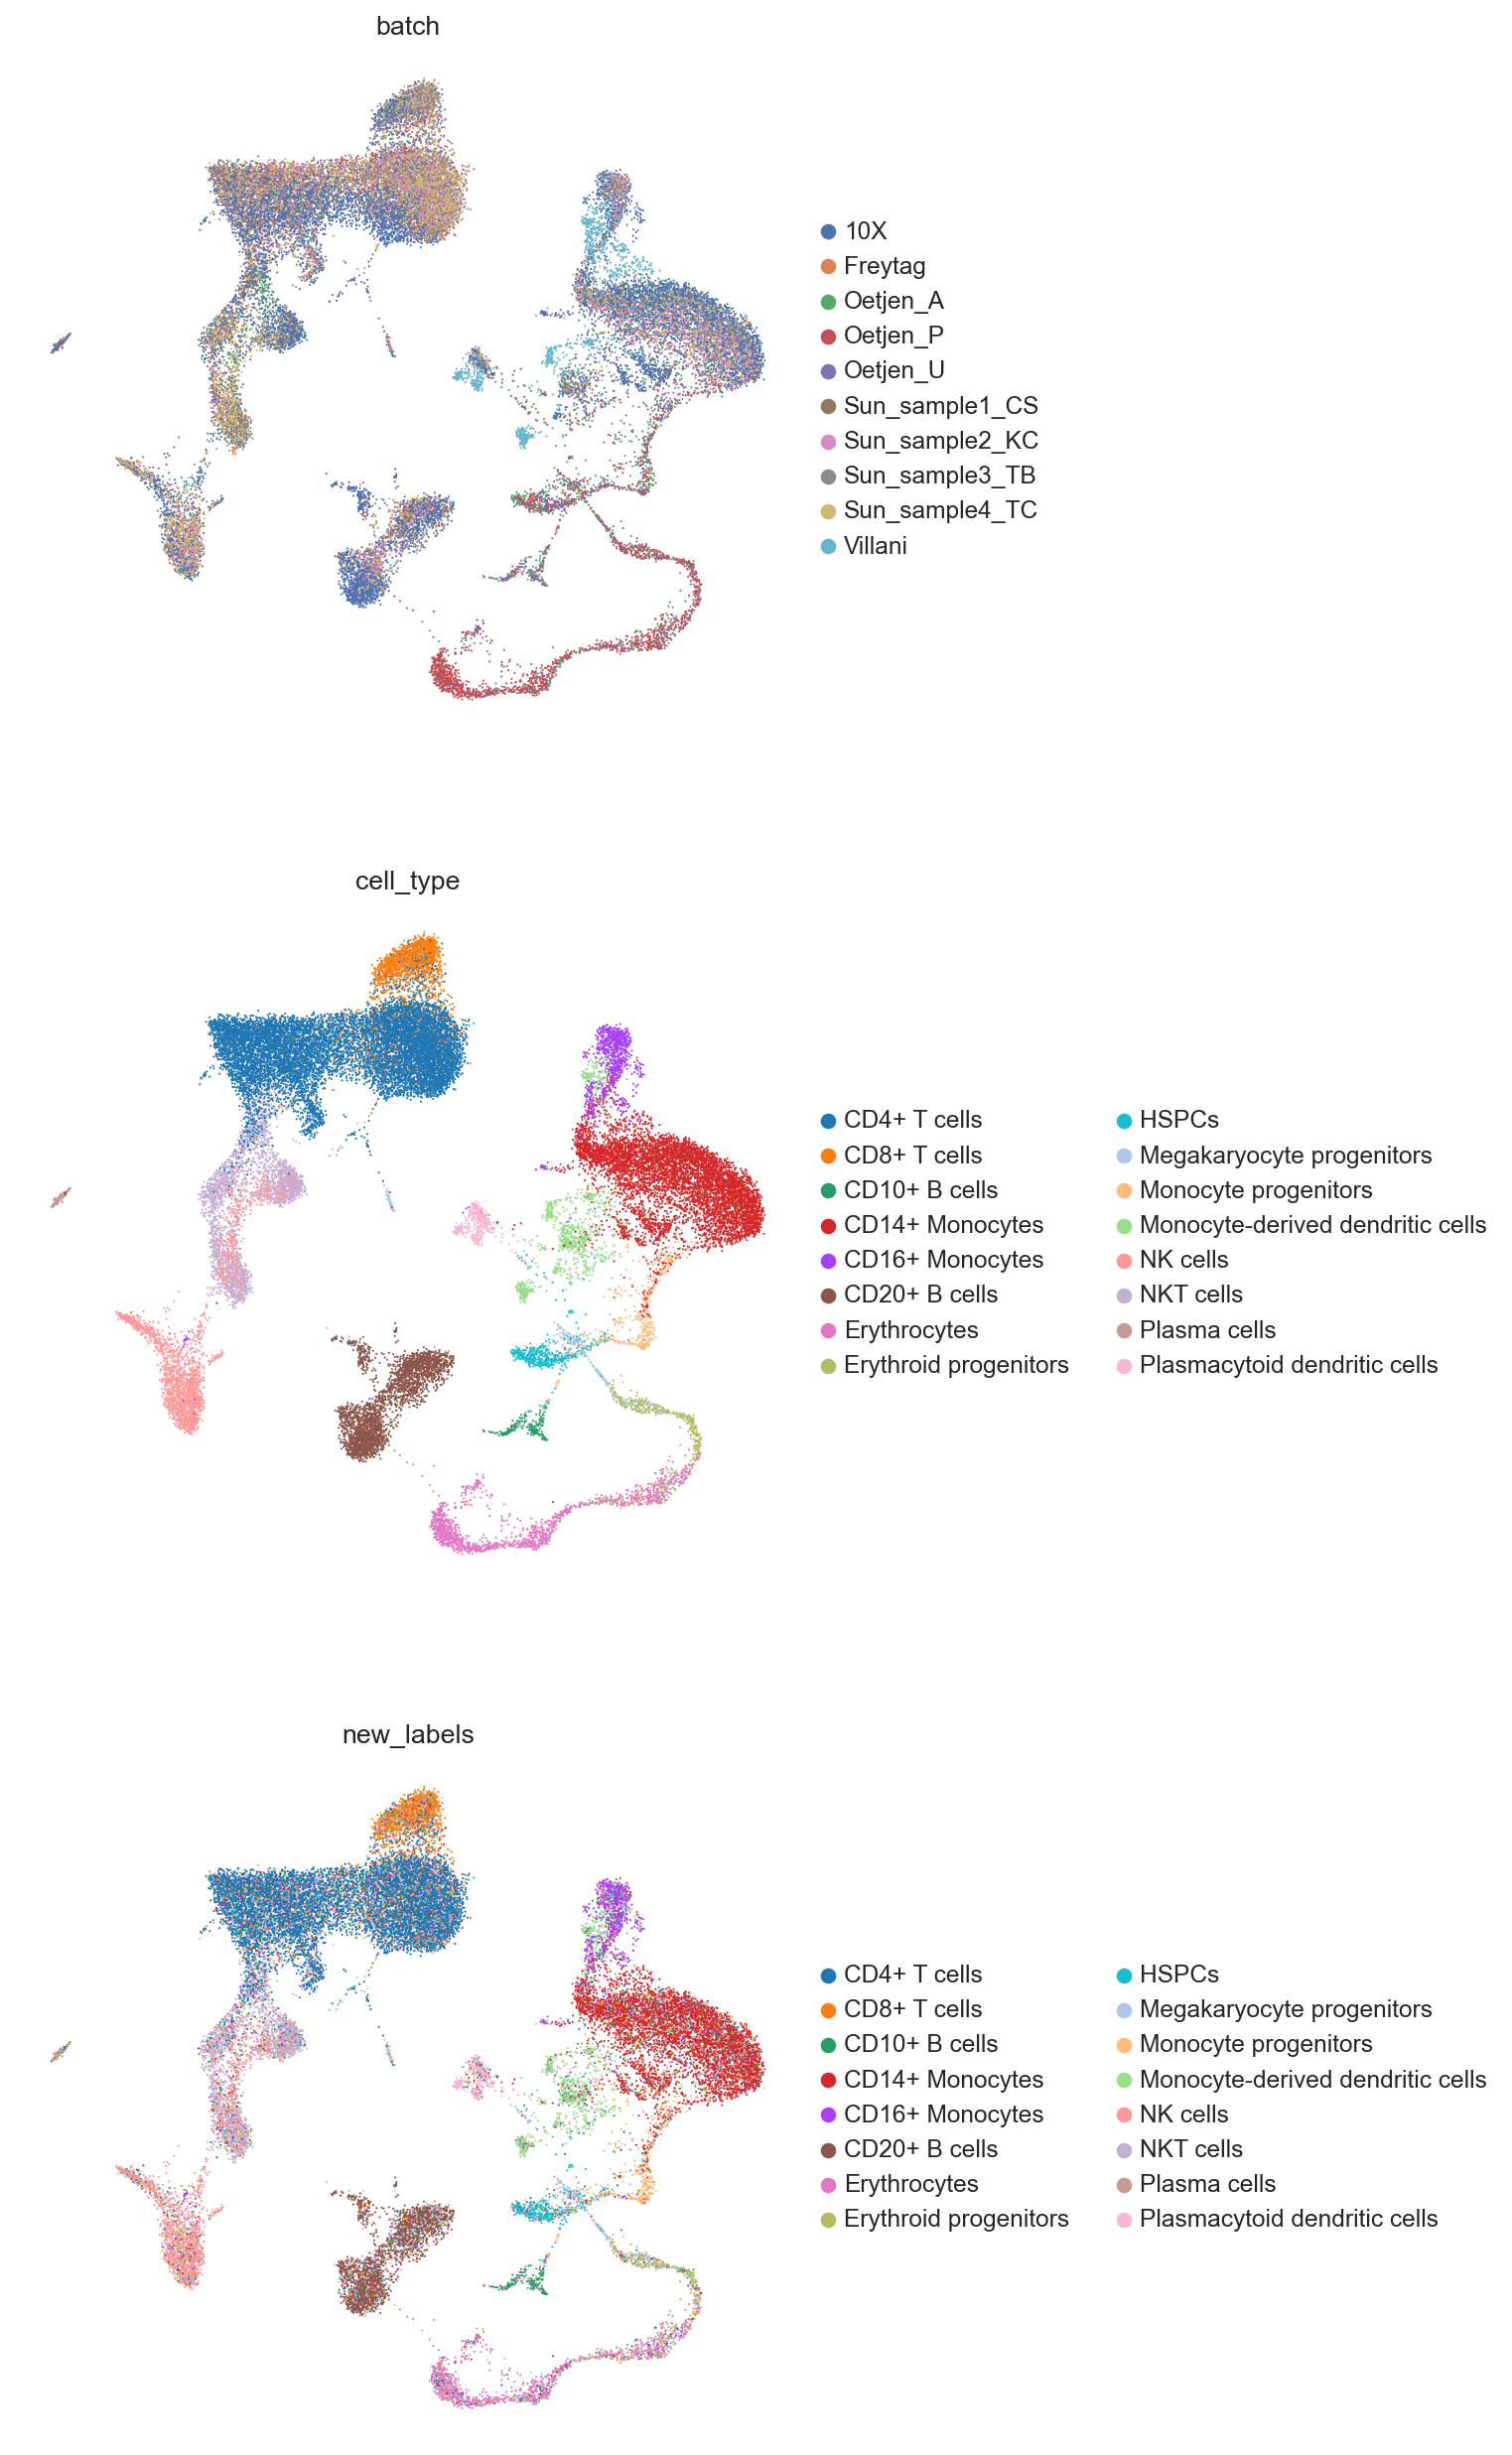

In [24]:
sc.pl.umap(adata, color=["batch", "cell_type", "new_labels"], frameon=False, ncols=1)

# scDREAMER

In [33]:
pca_embeddings = pd.read_csv('../R_human_immune/embeddings/randomly_wrong_human_immune_30_scdreamer_embeddings.csv', index_col=0)
adata.obsm['X_scDREAMER'] = pca_embeddings.values
sc.pp.neighbors(adata, use_rep="X_scDREAMER")
sc.tl.umap(adata, min_dist=0.5)

In [34]:
# Collect embeddings
embeddings_dict["X_scDREAMER"] = pca_embeddings.values

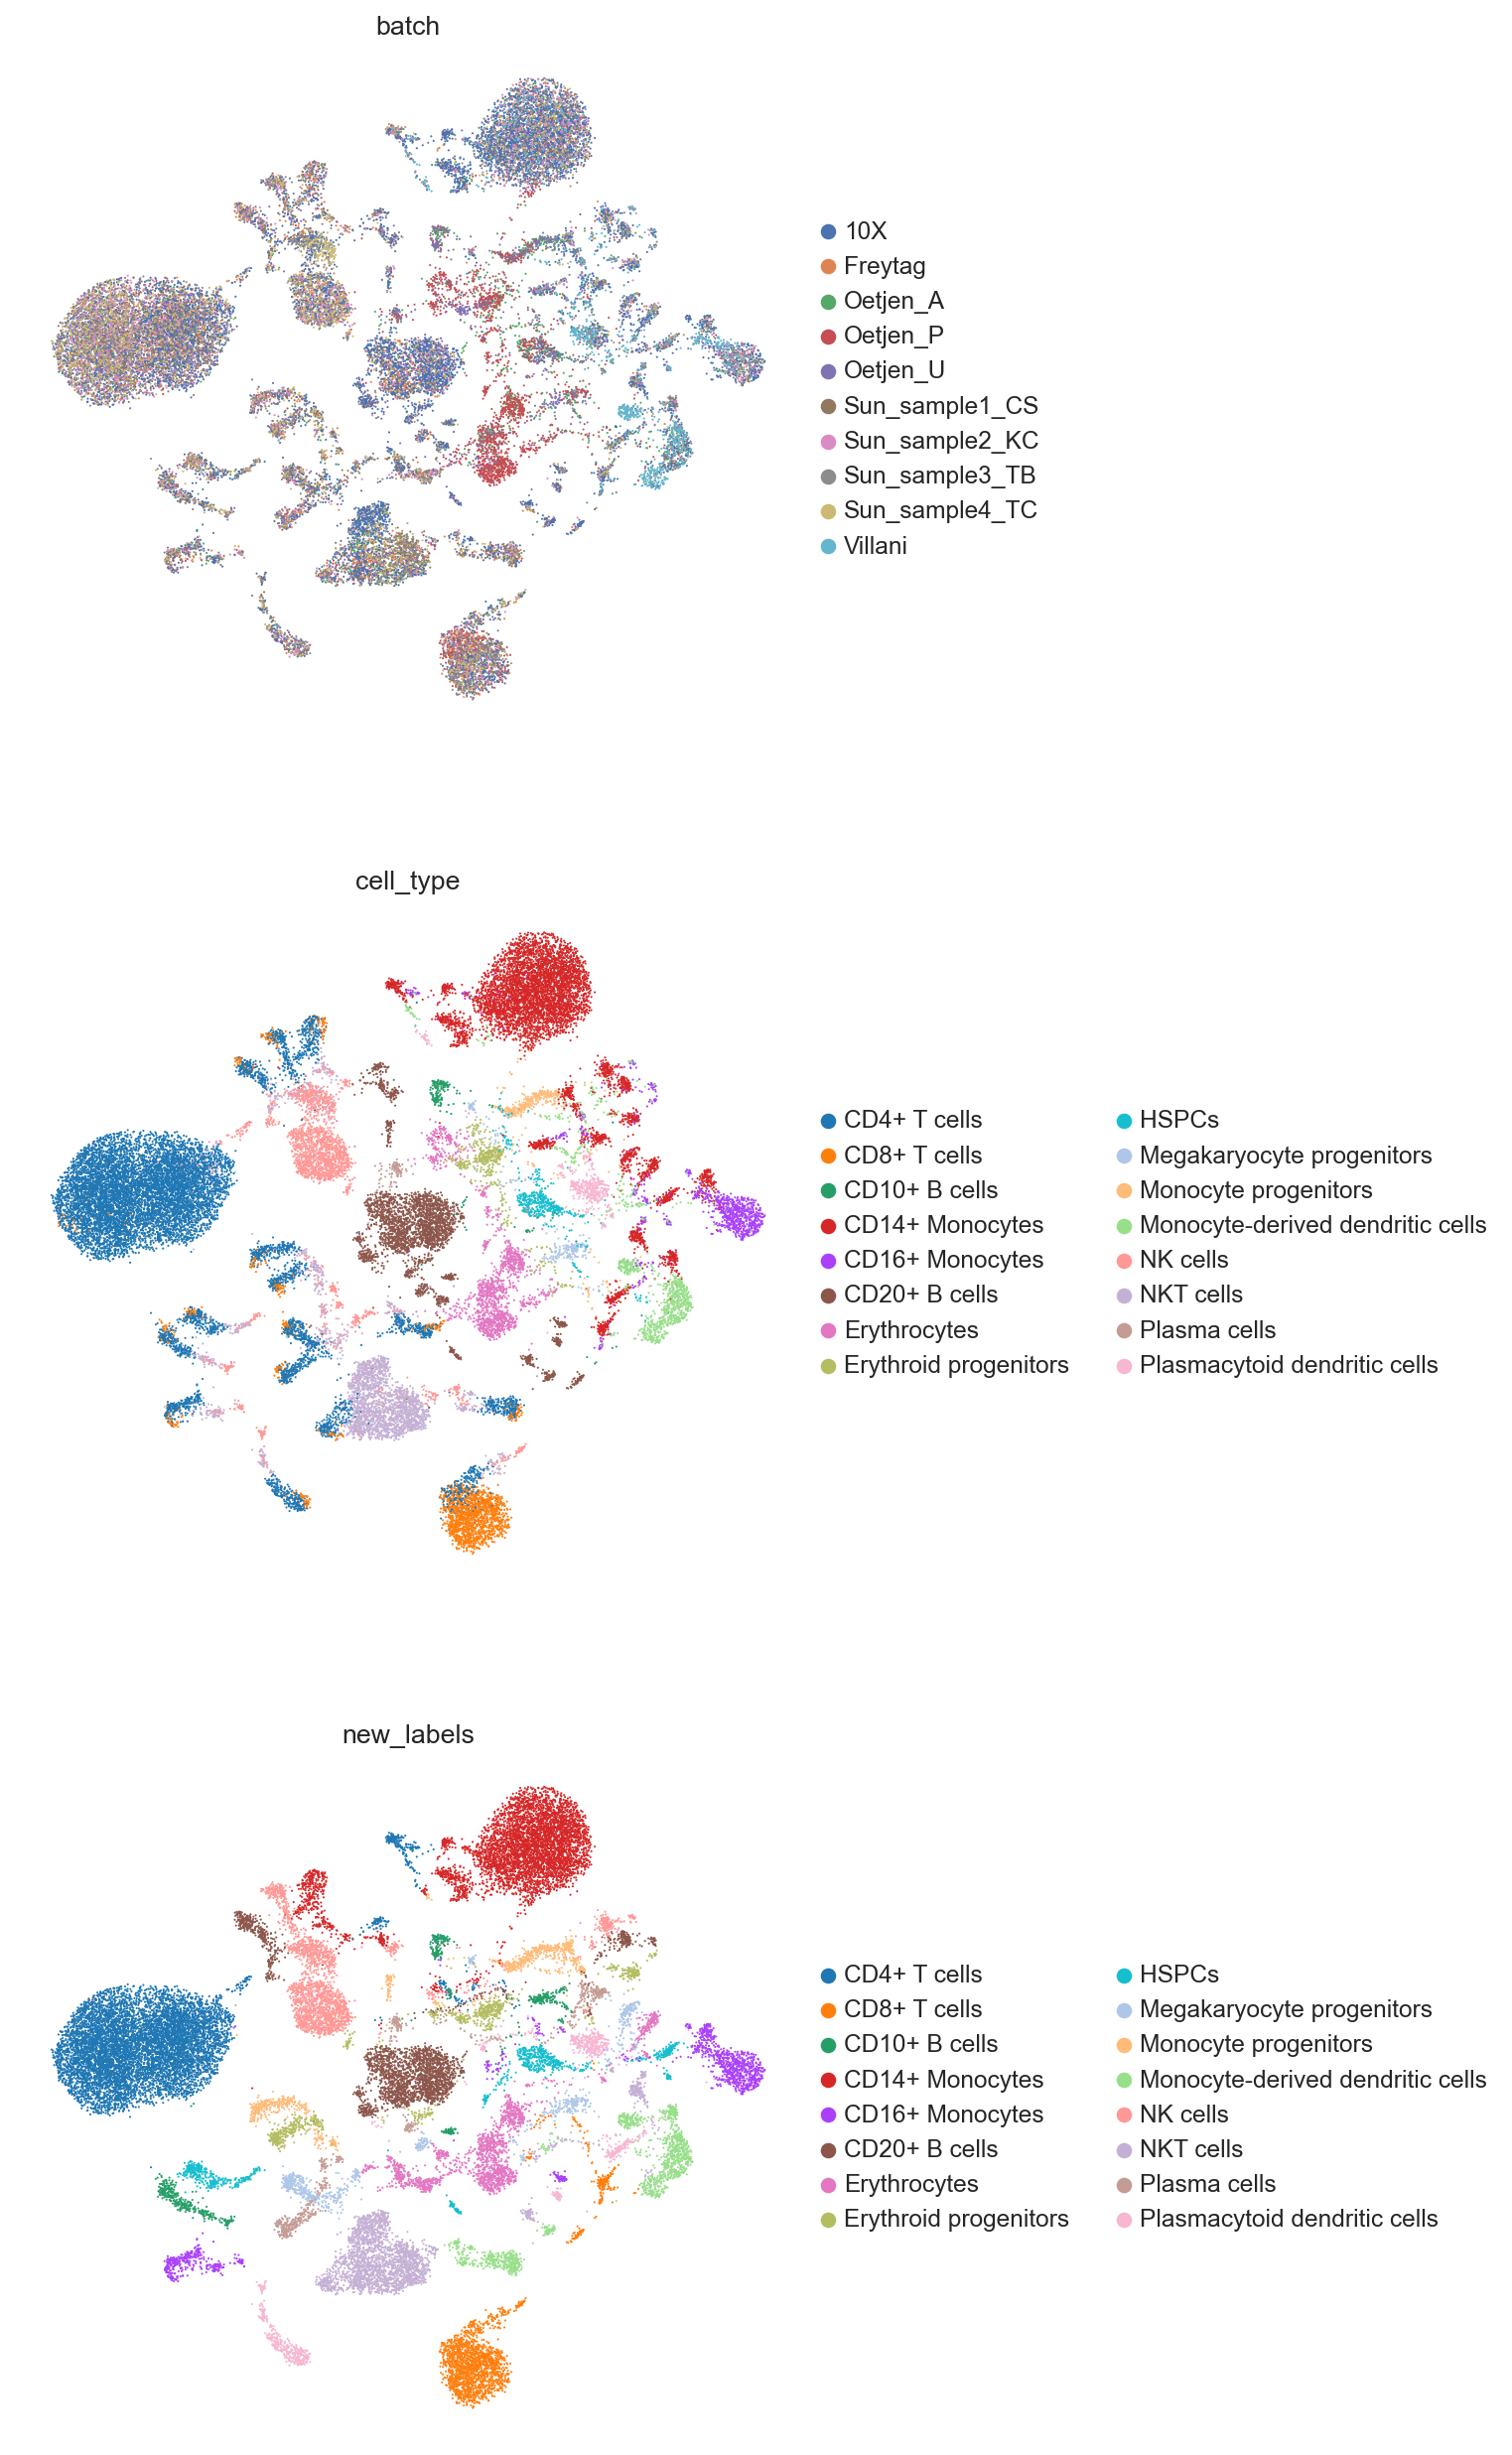

In [35]:
sc.pl.umap(adata, color=["batch", "cell_type", "new_labels"], frameon=False, ncols=1)

# ItClust

In [30]:
pca_embeddings = pd.read_csv('../R_human_immune/embeddings/randomly_wrong_human_immune_itclust_embeddings_30.csv', index_col=0)
adata.obsm['X_itclust'] = pca_embeddings.values
sc.pp.neighbors(adata, use_rep="X_itclust")
sc.tl.umap(adata, min_dist=0.5)

In [31]:
# Collect embeddings
embeddings_dict["X_itclust"] = pca_embeddings.values

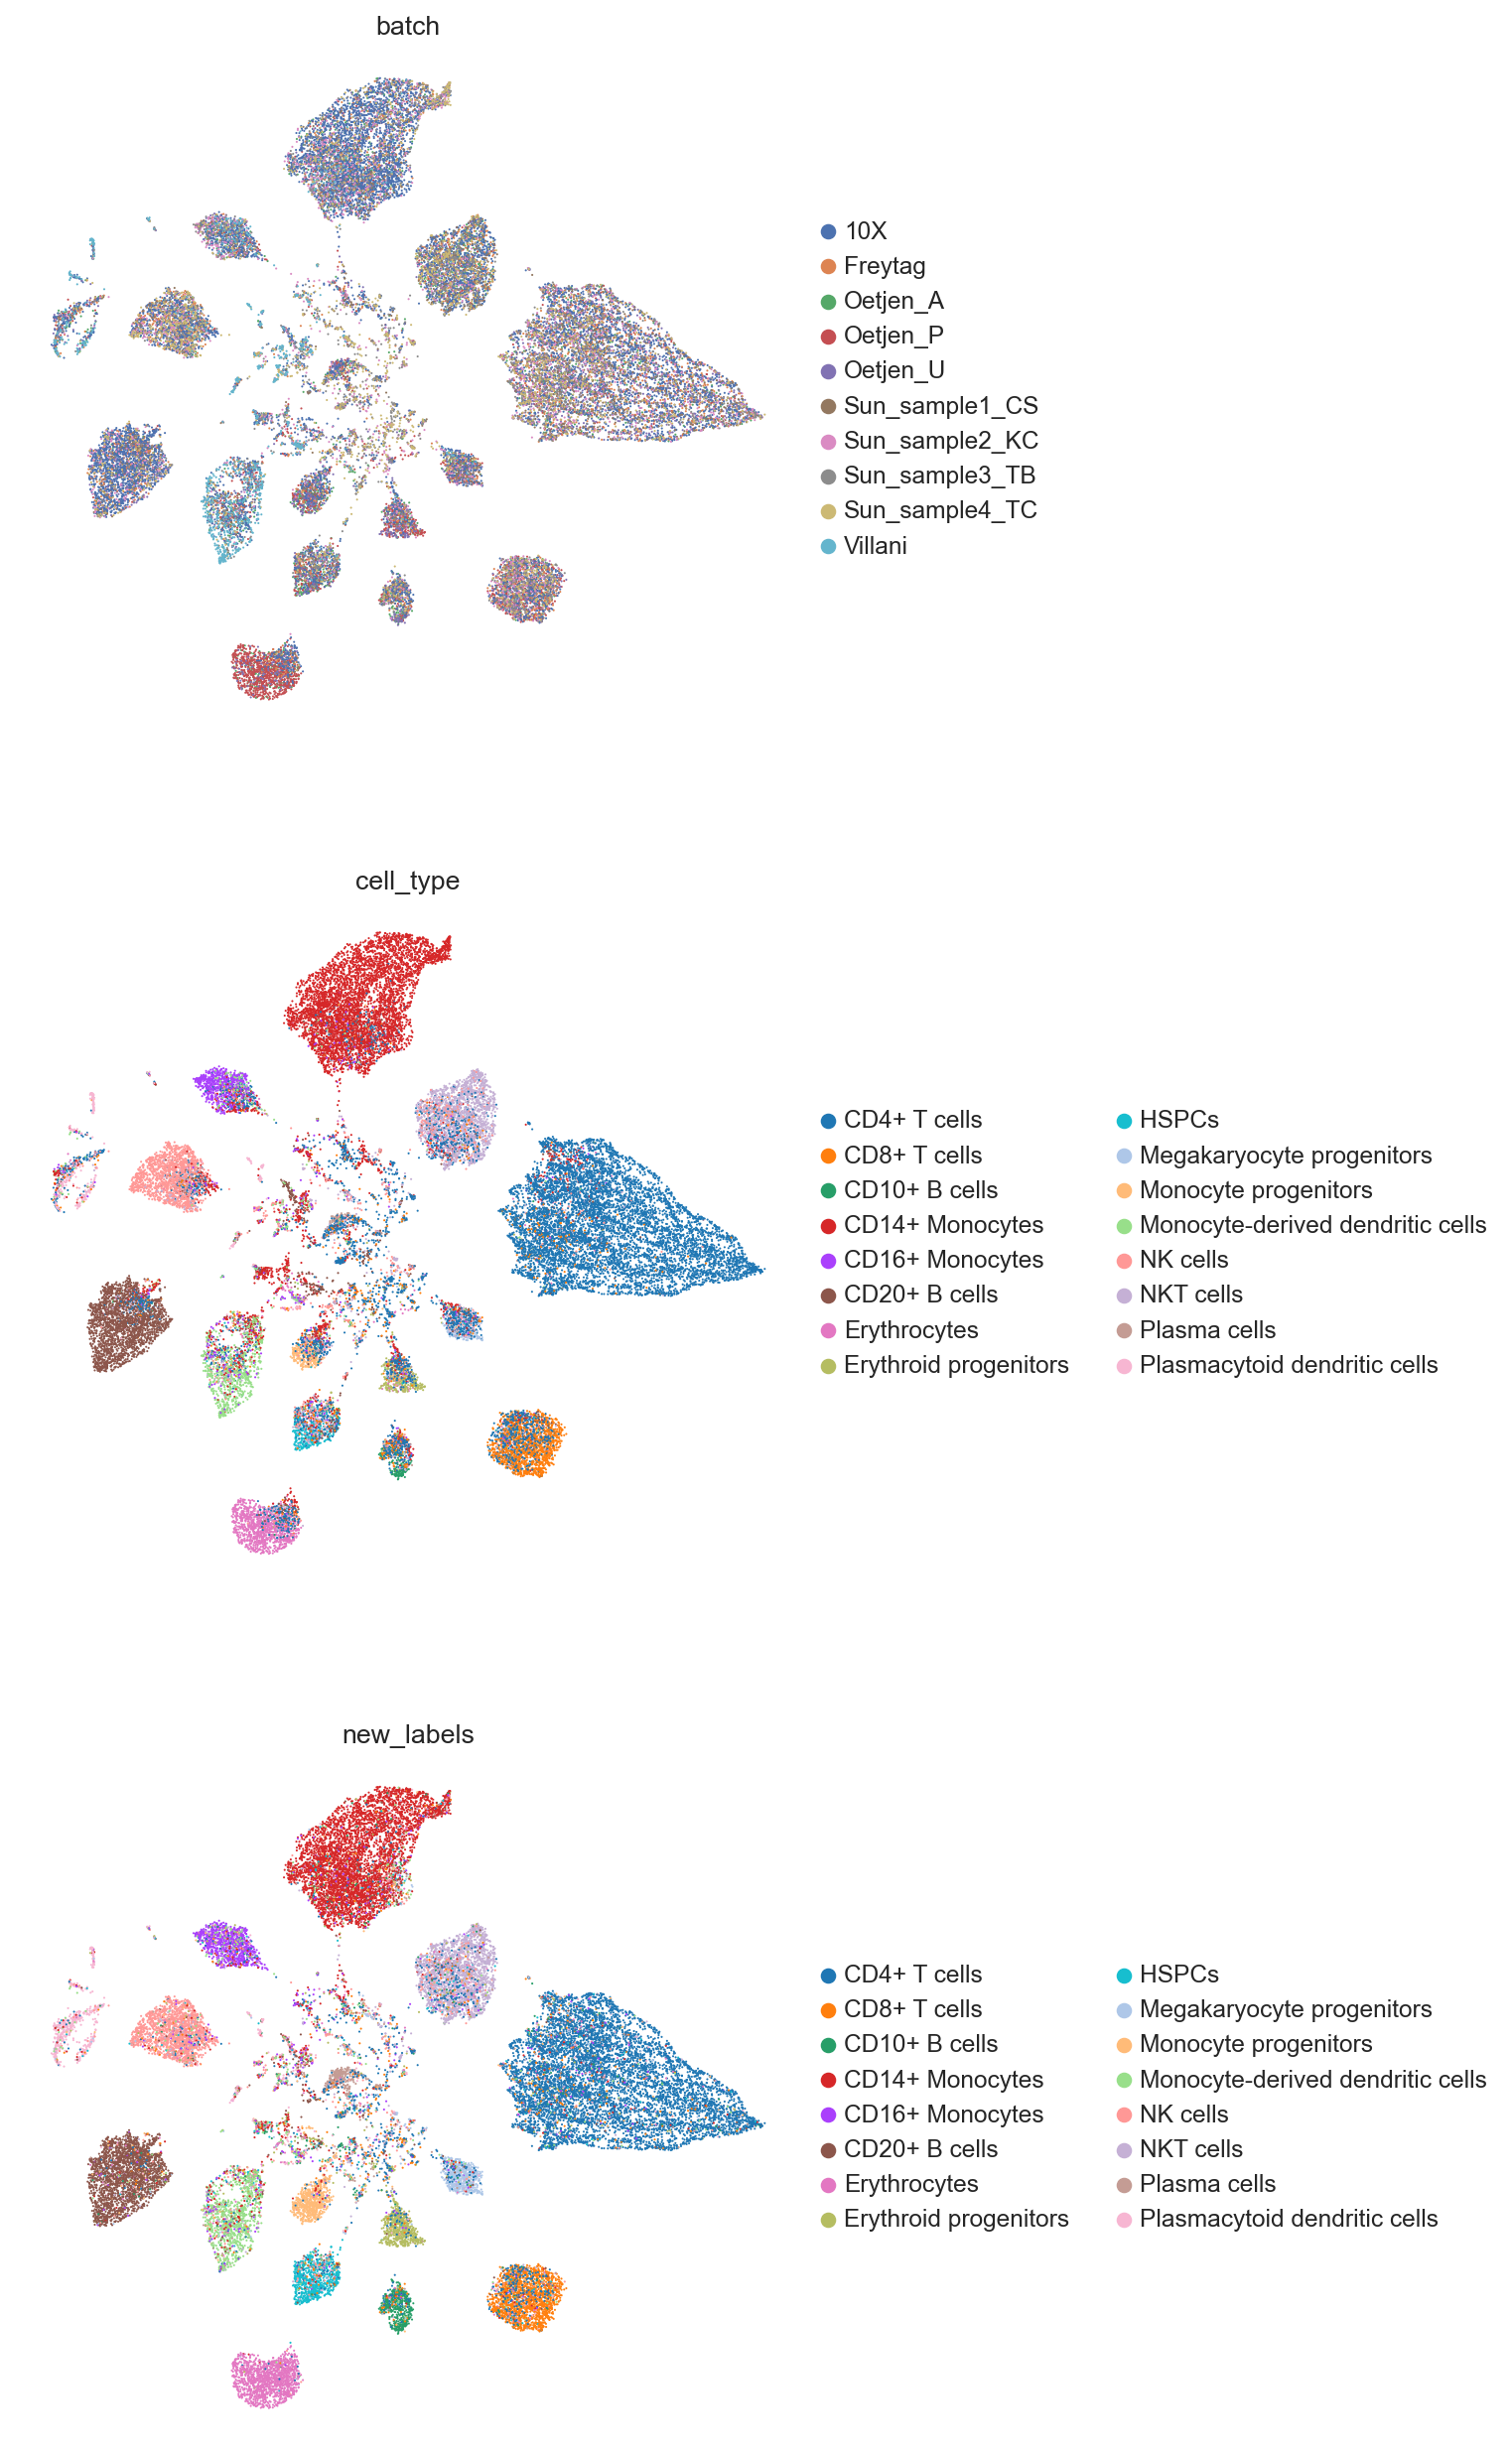

In [32]:
sc.pl.umap(adata, color=["batch", "cell_type", "new_labels"], frameon=False, ncols=1)

In [36]:
# save all the embeddings
# Concatenate embeddings and save to CSV
combined_embeddings = pd.concat(
    {key: pd.DataFrame(value, index=adata.obs_names) for key, value in embeddings_dict.items()},
    axis=1
)
combined_embeddings.to_csv("../embeddings/randomly_wrong_human_immune_30.csv")


# Metric Evaluation

## read the embeddings

In [ ]:
# Step 1: Read the CSV file into a DataFrame
combined_embeddings = pd.read_csv("../embeddings/randomly_wrong_human_immune_30.csv", index_col=0)

# Step 2: Ensure indices match
combined_embeddings = combined_embeddings.loc[adata.obs_names]

# Step 3: Split the DataFrame into separate DataFrames for each embedding
embedding_keys = ["X_scANVI", "X_scgen", "X_stacas", "X_scDREAMER", "X_itclust"]
embeddings_dict = {key: combined_embeddings.filter(like=key) for key in embedding_keys}

# Step 4: Assign the embeddings back to adata.obsm
for key, df in embeddings_dict.items():
    adata.obsm[key] = df.values

# Now `adata.obsm` contains the loaded embeddings

## Bio-conservation

In [ ]:
sc.pp.neighbors(adata, use_rep="X_scANVI")
scib.me.cluster_optimal_resolution(adata, cluster_key="cluster", label_key="cell_type")
df1_1 = scib.me.metrics(adata, adata_int=adata, silhouette_=True, ilisi_=True, graph_conn_=True, ari_=True, nmi_= True, isolated_labels_=True, isolated_labels_f1_=True, clisi_=True, isolated_labels_asw_=True,  batch_key='batch', label_key = 'cell_type', embed = 'X_scANVI')

In [ ]:
sc.pp.neighbors(adata, use_rep="X_scgen")
scib.me.cluster_optimal_resolution(adata, cluster_key="cluster", label_key="cell_type")
df2_1 = scib.me.metrics(adata, adata_int=adata, silhouette_=True, ilisi_=True, graph_conn_=True, ari_=True, nmi_= True, isolated_labels_=True, isolated_labels_f1_=True, clisi_=True, isolated_labels_asw_=True,  batch_key='batch', label_key = 'cell_type', embed = 'X_scgen')

In [ ]:
sc.pp.neighbors(adata, use_rep="X_stacas")
scib.me.cluster_optimal_resolution(adata, cluster_key="cluster", label_key="cell_type")
df3_1 = scib.me.metrics(adata, adata_int=adata, silhouette_=True, ilisi_=True, graph_conn_=True, ari_=True, nmi_= True, isolated_labels_=True, isolated_labels_f1_=True, clisi_=True, isolated_labels_asw_=True,  batch_key='batch', label_key = 'cell_type', embed = 'X_stacas')

In [ ]:
# Adding new columns to each dataframe
df1_1['scANVI'] = df1_1.iloc[:, 0]
df2_1['scGEN'] = df2_1.iloc[:, 0]
df3_1['STACAS'] = df3_1.iloc[:, 0]

# Selecting only the new columns to avoid duplicate data
df1_1 = df1_1[['scANVI']]
df2_1 = df2_1[['scGEN']]
df3_1 = df3_1[['STACAS']]

# Merging the dataframes along the columns
merged_df_cell = pd.concat([df1_1, df2_1, df3_1], axis=1)

merged_df_cell